In [3]:
import torch
from torch.nn import PoissonNLLLoss
n_tasks = 10000
n_train = 40
lr = 0.05
max_steps = 10000
tol = 1e-10


In [4]:
def sample_data(n_tasks, n_points, d, ws = None, scale=0.32, loss_type="poisson", r=None):
    xs = torch.randn(n_tasks, n_points, d)
    if not isinstance(ws, torch.Tensor):
        ws = scale * torch.randn(n_tasks, d, 1)
    logits = xs @ ws
    mu = torch.exp(logits.clamp(max=4))  # shape: [n_tasks, n_points, 1]

    if loss_type == "poisson":
        ys = torch.poisson(mu).squeeze(-1)

    elif loss_type == "nb":
        # r is a scalar or float constant
        r_tensor = torch.tensor(r, dtype=mu.dtype, device=mu.device)
        logits_nb = torch.log(r_tensor) - torch.log(r_tensor + mu)
        dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, logits=logits_nb)
        ys = dist_nb.sample().squeeze(-1)

    else:
        raise ValueError(f"Unsupported data_type: {loss_type}. Use 'poisson' or 'neg_binomial'.")

    return xs, ys, ws

In [47]:
xs_all, ys_all, ws = sample_data(n_tasks, 40, 10, scale=0.32, loss_type="poisson", r=1)
print(f"xs_all.shape: {xs_all.shape}")
print(f"ys_all.shape: {ys_all.shape}")
print(f"ws.shape: {ws.shape}")

xs_all.shape: torch.Size([10000, 40, 10])
ys_all.shape: torch.Size([10000, 40])
ws.shape: torch.Size([10000, 10, 1])


In [48]:
LOSS_REGISTRY = {}

def register_loss(name):
    def decorator(fn):
        LOSS_REGISTRY[name] = fn
        return fn
    return decorator

@register_loss('poisson')
def poisson_loss(pred, targets, **kwargs):
    return PoissonNLLLoss(log_input=True, full=True, reduction='none')(pred, targets)


@register_loss('nb')
def nb_nll_loss(preds, targets, r):
    mu = torch.exp(preds)  
    r = torch.tensor(r, device=mu.device, dtype=mu.dtype, requires_grad=False)  
    logits = torch.log(r) - torch.log(r + mu)
    dist = torch.distributions.NegativeBinomial(total_count=r, logits=logits)
    return -dist.log_prob(targets)




In [ ]:
import torch
from torch.nn import PoissonNLLLoss
from tqdm import tqdm
import random

torch.manual_seed(42)
def run_oracle_on_random_context(context_len, n_tasks, d, lr, max_steps, tol, device="cuda", scale=0.32, r=None, loss_type="poisson", compare_loss=None):
    xs_all, ys_all, ws = sample_data(n_tasks, context_len, d, scale=scale, loss_type=loss_type, r=r)

    # Evaluate only at max context size (i.e., context_len - 1)
    t = context_len - 1
    xs_train = xs_all[:, :t, :].to(device)
    ys_train = ys_all[:, :t].to(device)
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)

    loss_fn = LOSS_REGISTRY[loss_type]

    w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
    opt = torch.optim.Adam([w_hat], lr=lr)

    prev = float("inf")
    for step in range(1, max_steps + 1):
        logits = (xs_train @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred = logits
        loss = loss_fn(pred, ys_train, r=r).mean()
        
        l2_penalty = (0.5 / scale**2) * w_hat.pow(2).sum() / (n_tasks * t) 
        loss += l2_penalty
    
        
        if abs(prev - loss.item()) < tol:
            print(f"[Context {t}] Converged at step {step}")
            break
        prev = loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    else:
        print(f"[Context {t}] DID NOT converge (final Δloss={abs(prev - loss.item()):.2e})")

        
    with torch.no_grad():
        logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
        pred_test = logits_test
        loss = loss_fn(pred_test, ys_test, r=r)
        print(loss_type, loss.mean().item(), loss.std().item())
    
    if compare_loss:
        xs_all, ys_all, _ = sample_data(n_tasks, context_len, d, scale=scale, loss_type=compare_loss, ws=ws, r=r)
        t = context_len - 1
        xs_train = xs_all[:, :t, :].to(device)
        ys_train = ys_all[:, :t].to(device)
        xs_test = xs_all[:, t:t+1, :].to(device)
        ys_test = ys_all[:, t:t+1].to(device)
        
        with torch.no_grad():
            logits_test = (xs_test @ w_hat).squeeze(-1).clamp(min=-4, max=4)
            pred_test = logits_test
            comp_loss = LOSS_REGISTRY[compare_loss](pred_test, ys_test, r=r)
            print(compare_loss, comp_loss.mean().item(), comp_loss.std().item())

    
    
    return loss.mean().item()


device = "cuda" if torch.cuda.is_available() else "cpu"

run_oracle_on_random_context(context_len=80, n_tasks=1000, d=10, lr=0.01, max_steps=10000, 
                             tol=1e-10, scale=2, r = 5, device=device, loss_type="nb", compare_loss=None)

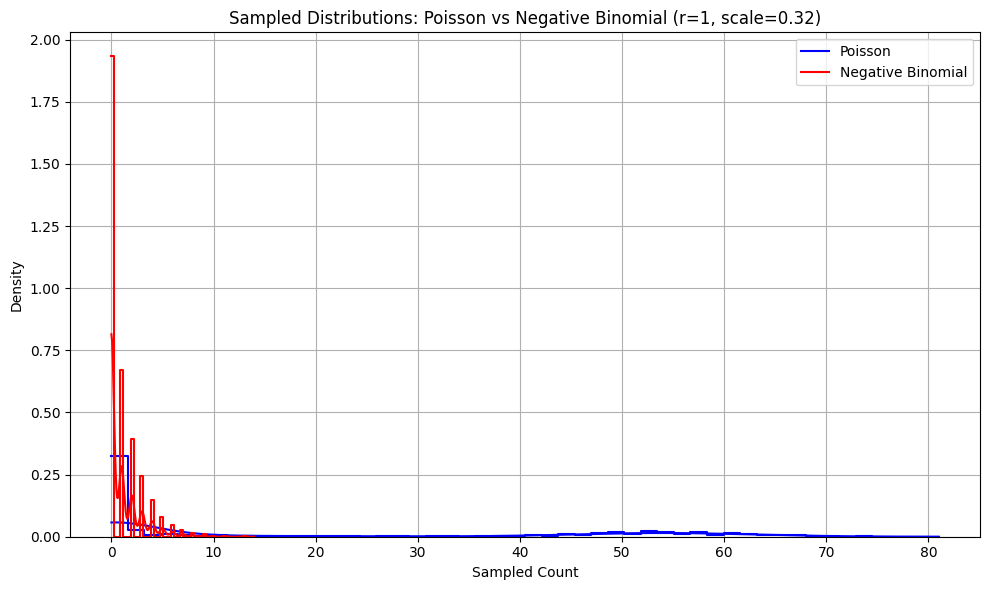

In [181]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def sample_and_plot_distributions(n_samples=10000, d=10, scale=2, r=2):
    # Generate random inputs
    xs = torch.randn(n_samples, d)
    ws = scale * torch.randn(d, 1)
    logits = xs @ ws
    mu = torch.exp(logits.clamp(max=4)).squeeze()

    # Sample from Poisson
    poisson_samples = torch.poisson(mu).cpu().numpy()

    # Sample from Negative Binomial
    r_tensor = torch.tensor(r, dtype=mu.dtype)
    logits_nb = torch.log(r_tensor) - torch.log(r_tensor + mu)
    dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, logits=logits_nb)
    nb_samples = dist_nb.sample().cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(poisson_samples, bins=50, color='blue', label='Poisson', stat='density', kde=True, element='step', fill=False)
    sns.histplot(nb_samples, bins=50, color='red', label='Negative Binomial', stat='density', kde=True, element='step', fill=False)
    plt.title("Sampled Distributions: Poisson vs Negative Binomial (r=1, scale=0.32)")
    plt.xlabel("Sampled Count")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run this in your own environment
sample_and_plot_distributions()


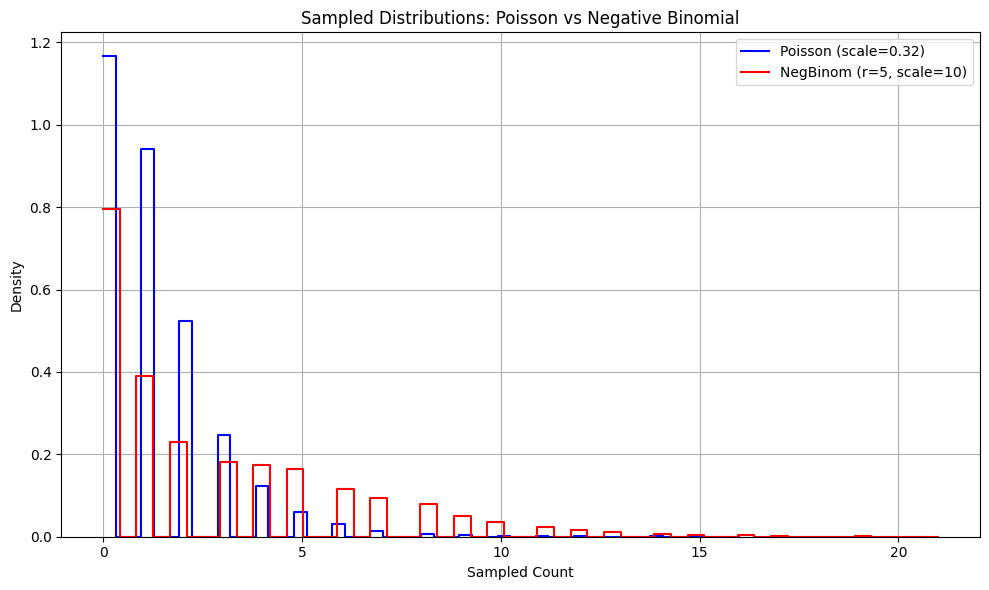

In [29]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def sample_and_plot_distributions(n_samples=10000, d=10, scale_poisson=2, r_nb=2, scale_nb=2):
    # --- Generate inputs ---
    xs = torch.randn(n_samples, d)

    # --- Poisson sampling ---
    ws_poisson = scale_poisson * torch.randn(d, 1)
    logits_poisson = xs @ ws_poisson
    mu_poisson = torch.exp(logits_poisson.clamp(-4,4)).squeeze()
    poisson_samples = torch.poisson(mu_poisson).cpu().numpy()

    # --- Negative Binomial sampling ---
    ws_nb = scale_nb * torch.randn(d, 1)
    logits_nb_input = xs @ ws_nb
    mu_nb = torch.exp(logits_nb_input.clamp(-4,4)).squeeze()
    r_tensor = torch.tensor(r_nb, dtype=mu_nb.dtype, device=mu_nb.device)
    logits_nb = torch.log(r_tensor) - torch.log(r_tensor + mu_nb)
    dist_nb = torch.distributions.NegativeBinomial(total_count=r_tensor, logits=logits_nb)
    nb_samples = dist_nb.sample().cpu().numpy()

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    sns.histplot(poisson_samples, bins=50, color='blue', label=f'Poisson (scale={scale_poisson})',
                 stat='density', element='step', fill=False)
    sns.histplot(nb_samples, bins=50, color='red', label=f'NegBinom (r={r_nb}, scale={scale_nb})',
                 stat='density', element='step', fill=False)
    plt.title("Sampled Distributions: Poisson vs Negative Binomial")
    plt.xlabel("Sampled Count")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
sample_and_plot_distributions(scale_poisson=0.32, scale_nb=10, r_nb=5)
